In [1]:
# load packages

# data wrangling
import pandas as pd
import numpy as np
import itertools

# math packages
import math

# visualizations
import matplotlib as mpl
import matplotlib.pyplot as plt
import pylab

# cluster class dependencies
from queue import PriorityQueue

In [2]:
# read in the data
c1 = pd.read_csv('c1.txt', sep="  ", header=None)
c1.head()

C:\Users\vaisu\.conda\envs\DataMining-env\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


,0,1,2
0,1,-6.912185,3.800000
1,2,-6.988086,4.000000
2,3,-9.922216,-4.982732
3,4,-8.956574,-4.414626
4,5,-7.976215,-3.982776


In [3]:
# cleaning data by dropping the index column
c1 = c1.drop([0], axis=1)
c1 = c1.rename(columns={1:'x1', 2:'x2'})
c1.head()

,x1,x2
0,-6.912185,3.800000
1,-6.988086,4.000000
2,-9.922216,-4.982732
3,-8.956574,-4.414626
4,-7.976215,-3.982776


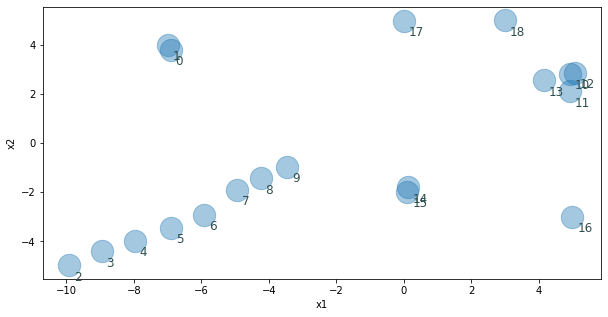

In [4]:
# we should start by looking at a plot of the data
fig, ax = plt.subplots(figsize=(10,5))
c1.plot(kind='scatter', x='x1', y='x2', alpha=0.4, s=500,
        ax=ax)

for k, v in c1.iterrows():
    ax.annotate(k, v,
                xytext=(5,-15), textcoords='offset points',
                family='sans-serif', fontsize=12, color='darkslategrey')

In [5]:
# then it looks like there are opportunites for clustering
# lets compute pairwise distances and add them
# to a priority que 

In [6]:
def printClusters(result):
    for cluster in result.getList():
        print(cluster.getPointList())

In [7]:
# a class for cluster objects
class Cluster:
    
#     def __init__(self, triplet, size):
        
#         # initialize a 0 array of length size
#         self.pointList = np.zeros(size)
        
#         # add the intial points
#         self.addPoint(triplet[1])
#         self.addPoint(triplet[2])
#         return

    def __init__(self, point):
        
        self.pointList = []
        self.size = 0
#         initialize a 0 array of length size
#         self.pointList = np.zeros(size)
        
        # add the initial point
        self.addPoint(point)
        return
    
    def getPointList(self):
        return self.pointList
    
    def addPoint(self, newPoint):
        self.pointList.append(newPoint)
        self.size += 1
        return
    
    def getClusterSize(self):
        return self.size
    
    def computeMean(self, data):
        xMean = 0
        yMean = 0
        
        for point in self.pointList:
            xMean += data[point][0]
            yMean += data[point][1]
            
        xMean = xMean / self.size
        yMean = yMean / self.size
        
        return [xMean, yMean]
    
#     def hasPoint(self, newPoint):
#         if self.pointList[newPoint] == 1:
#             return True
#         else:
#             return False

In [8]:
# a container for cluster objects and cluster operations
class clusterList:
    
    def __init__(self, data, distanceType):
        self.list = []
        self.size = 0
        self.data = data
        self.pq = PriorityQueue()
        self.distanceType = distanceType
        return
    
    def addCluster(self, cluster):
        self.list.append(cluster)
        self.size += 1
        return
    
    def deleteCluster(self, index):
        del self.list[index]
        self.size -= 1
        return
    
    def getClusterDistance(self, c1, c2):
        
        if (self.distanceType == "Single-Link"):
            return self.getMinDistance(c1, c2)
        elif (self.distanceType == "Complete-Link"):
            return self.getMaxDistance(c1, c2)
        elif (self.distanceType == "Mean-Link"):
            return self.getMeanDistance(c1, c2)
    
    def getMaxDistance(self, c1, c2):
        c1Points = c1.getPointList()
        c2Points = c2.getPointList()
        
        # initialize the minimum value 
        maxD = self.euclideanDistance(self.data[c1Points[0]], self.data[c2Points[0]])
        
        # O(n^2) search for a better min
        for c1P in c1Points:
#             print("c1: ", c1P)
            for c2P in c2Points:
#                 print("c2: ", c2P)
                D = self.euclideanDistance(self.data[c1P], self.data[c2P])
#                 print("Distance between {} and {} = {}".format(c1P, c2P, D))
                if D > maxD:
                    maxD = D
                    
        return maxD
    
    def getMeanDistance(self, c1, c2):
        c1Mean = c1.computeMean(self.data)
        c2Mean = c2.computeMean(self.data)
        return self.euclideanDistance(c1Mean, c2Mean)
    
    def getMinDistance(self, c1, c2):
        c1Points = c1.getPointList()
        c2Points = c2.getPointList()
        
        # initialize the minimum value 
        minD = self.euclideanDistance(self.data[c1Points[0]], self.data[c2Points[0]])
        
        # O(n^2) search for a better min
        for c1P in c1Points:
#             print("c1: ", c1P)
            for c2P in c2Points:
#                 print("c2: ", c2P)
                D = self.euclideanDistance(self.data[c1P], self.data[c2P])
#                 print("Distance between {} and {} = {}".format(c1P, c2P, D))
                if D < minD:
                    minD = D
                    
        return minD
    
    def insertCluster(self, cluster, index):
        self.list[index] = cluster
        return
    
    def mergeClusters(self, index1, index2):
        
        # extract the two clusters
        fromCluster = self.list[index2]
        toCluster = self.list[index1]
        
        # copy points from one to cluster to the other
        for point in fromCluster.getPointList():
            toCluster.addPoint(point)
        
        # re-insert the merged cluster
        self.insertCluster(toCluster, index1)
        
        # delete the first cluster
        self.deleteCluster(index2)
        
        return
    
    def compareAllClusters(self):
        
        # get list of all permutations between cluster indices
        clusterPairs = self.getClusterPairs()
        
        # loop through list of cluster pairs and compute the distance
        for i in range(len(clusterPairs)):
            c1_index = clusterPairs[i][0]
            c2_index = clusterPairs[i][1]
            c1 = self.list[c1_index]
            c2 = self.list[c2_index]
            d = self.getClusterDistance(c1, c2)
            
            # store the distance in the priority queue
            self.pq.put((d, c1_index, c2_index))
            
        return
    
    def renewPriorityQ(self):
        self.pq = PriorityQueue()
    
    def getClosestCluster(self):
        return self.pq.get()
        
    # lets get a list of all row pairs
    def getClusterPairs(self):
        t = []
        for i in range(self.size):
            t.append(i)

        result = list(itertools.combinations(t, 2))

        return result

    def getCluster(self, index):
        return self.list[index]
    
    def getList(self):
        return self.list
    
    def isEmpty(self):
        if (len(self.list) > 0):
            return False
        else:
            return True
        
    def getSize(self):
        return self.size
    
    def repairIndices(self):
        inds = []
        for i in range(len(self.list)):
            inds.append(i)
        
    
    # now a helper method to compute euclidean distance
    def euclideanDistance(self, vec1, vec2):
        result = 0
        for i in range(len(vec1)):
            pairDiff = (vec1[i] - vec2[i])
            result += (pairDiff * pairDiff)

        return math.sqrt(result)

In [9]:
def genClusters(data, s_type):

    # initialize empty cluster list
    cList = clusterList(data.to_numpy(), s_type)

    # initialize clusters with 1 point each and add them to the cluster list
    for i in range(len(data)):
        cList.addCluster(Cluster(i))
        
    # loop and merge
    while(cList.getSize() > 4):
        
        # compute all distances between clusters
        cList.compareAllClusters()
        
        # get the distance and indices of the closest clusters
        cPair = cList.getClosestCluster()
        
        # merge the two closest clusters
        cList.mergeClusters(cPair[1], cPair[2])
        
        # clear the priority queue
        cList.renewPriorityQ()
    
    return cList

In [10]:
singleLinkClusters = genClusters(c1, "Single-Link")

In [11]:
printClusters(singleLinkClusters)

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9, 14, 15]
[10, 12, 11, 13, 18, 17]
[16]


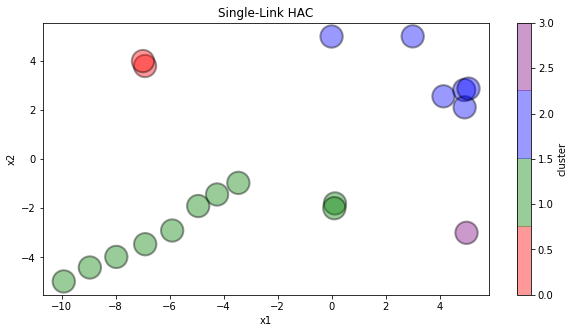

In [12]:
c1['cluster'] = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 3, 2, 2]

# we should start by looking at a plot of the data
fig, ax = plt.subplots(figsize=(10,5))

# colors = ['red','green','blue','purple', 'grey']
colors = ['red', 'green', 'blue', 'purple']

c1.plot(kind='scatter', x='x1', y='x2', c='cluster', alpha=.4, s=500, edgecolor='k', linewidth = 2,
        cmap=pylab.mpl.colors.ListedColormap(colors), ax=ax)

plt.title("Single-Link HAC")
plt.show()

In [13]:
c1 = c1.drop(['cluster'], axis=1)

In [14]:
completeLinkClusters = genClusters(c1, 'Complete-Link')

In [15]:
printClusters(completeLinkClusters)

[0, 1, 5, 6, 7, 8, 9]
[2, 3, 4]
[10, 12, 11, 13, 17, 18]
[14, 15, 16]


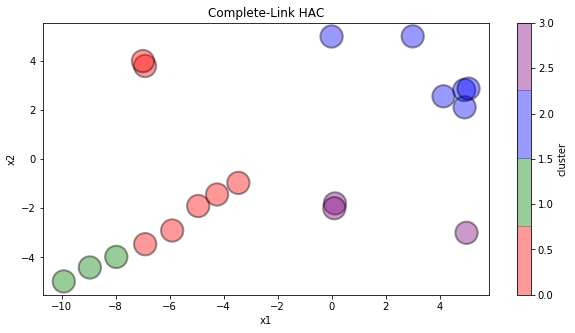

In [16]:
c1['cluster'] = [0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 2, 2, 2, 2, 3, 3, 3, 2, 2]

# we should start by looking at a plot of the data
fig, ax = plt.subplots(figsize=(10,5))

# colors = ['red','green','blue','purple', 'grey']
colors = ['red', 'green', 'blue', 'purple']

c1.plot(kind='scatter', x='x1', y='x2', c='cluster', alpha=.4, s=500, edgecolor='k', linewidth = 2,
        cmap=pylab.mpl.colors.ListedColormap(colors), ax=ax)

plt.title("Complete-Link HAC")
plt.show()

In [17]:
c1 = c1.drop(['cluster'], axis=1)

In [18]:
meanLinkClusters = genClusters(c1, 'Mean-Link')

In [19]:
printClusters(meanLinkClusters)

[0, 1]
[2, 3, 4, 5, 6, 7, 8, 9]
[10, 12, 11, 13, 18, 17]
[14, 15, 16]


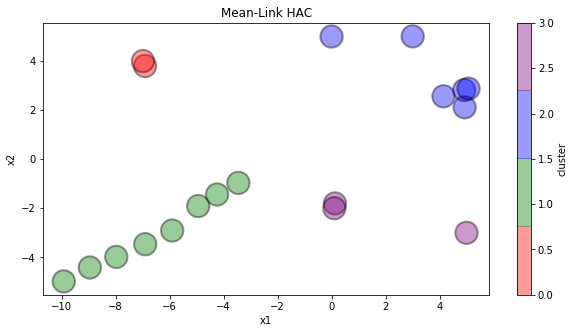

In [20]:
c1['cluster'] = [0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 2, 2] 

# we should start by looking at a plot of the data
fig, ax = plt.subplots(figsize=(10,5))

# colors = ['red','green','blue','purple', 'grey']
colors = ['red', 'green', 'blue', 'purple']

c1.plot(kind='scatter', x='x1', y='x2', c='cluster', alpha=.4, s=500, edgecolor='k', linewidth = 2,
        cmap=pylab.mpl.colors.ListedColormap(colors), ax=ax)

plt.title("Mean-Link HAC")

plt.show()